In [1]:
print('hello world')

hello world


# Classify station notebook

## The challenge
You should exclude 5 of the weather stations from this set. (You could do this by picking the 5 last stations alphabetically). 
Can you predict whether they fall in the Northern Third of the UK, Central Third of the UK or Southern Third of the UK using only the weather data? 
	- You have latitude data for all the weather stations, so that can give you the classification for each of the weather stations in your training set. 
To determine the latitude of the lines dividing the UK into three, you should note that the most northerly point has latitude 60.9 and the most southerly point has latitude 49.9. 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dataPath = '../data/weather/'
stationData = pd.read_csv(dataPath+'stationData.csv',index_col=[0,1,2],parse_dates=False)
stationData


tmax  tmin   af   rain    sun   asml     lat   long  \
station   yyyy mm                                                        
aberporth 1941 1    NaN   NaN  NaN   74.7    NaN  133.0  52.139 -4.570   
               2    NaN   NaN  NaN   69.1    NaN  133.0  52.139 -4.570   
               3    NaN   NaN  NaN   76.2    NaN  133.0  52.139 -4.570   
               4    NaN   NaN  NaN   33.7    NaN  133.0  52.139 -4.570   
               5    NaN   NaN  NaN   51.3    NaN  133.0  52.139 -4.570   
...                 ...   ...  ...    ...    ...    ...     ...    ...   
yeovilton 2020 2   10.8   4.5  2.0  117.4   63.1   20.0  51.006 -2.641   
               3   11.5   3.0  6.0   43.4  159.2   20.0  51.006 -2.641   
               4   17.5   5.3  3.0   39.8  235.0   20.0  51.006 -2.641   
               5   19.7   6.8  2.0    3.6  305.6   20.0  51.006 -2.641   
               6   20.5  11.0  0.0  103.0  187.6   20.0  51.006 -2.641   

                           gridRef  
station   yyyy mm                   
aberporth 1941 1   224100E 252100N  
               2   224100E 252100N  
               3   224100E 252100N  
               4   224100E 252100N  
               5   224100E 252100N  
...                            ...  
yeovilton 2020 2   355100E 123200N  
               3   355100E 123200N  
               4   355100E 123200N  
               5   355100E 123200N  
               6   355100E 123200N  

[37767 rows x 9 columns]

In [4]:
import numpy as np

def getThird(lat):
    maxLat = 60.9
    minLat = 49.9
    # tad extra to enforce within 3.
    return int((lat-minLat)/((maxLat+0.00001-minLat)/3))+1

thresholds = np.linspace(49.9,60.9,num=4)
print(thresholds)

['{:.2f}={}'.format(point,getThird(point)) for point in np.linspace(49.9,60.9,num=20)]

[49.9        53.56666667 57.23333333 60.9       ]


['49.90=1',
 '50.48=1',
 '51.06=1',
 '51.64=1',
 '52.22=1',
 '52.79=1',
 '53.37=1',
 '53.95=2',
 '54.53=2',
 '55.11=2',
 '55.69=2',
 '56.27=2',
 '56.85=2',
 '57.43=3',
 '58.01=3',
 '58.58=3',
 '59.16=3',
 '59.74=3',
 '60.32=3',
 '60.90=3']

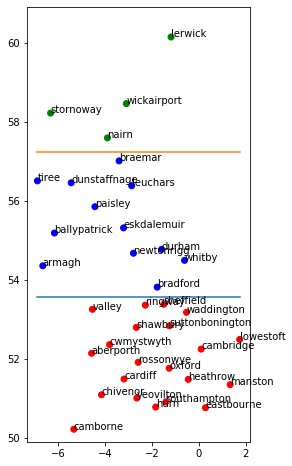

In [61]:
import matplotlib.colors
#pd.plotting.scatter_matrix(dfTrain.drop(columns='gridRef'))
def makeMap(df,predict=False) : 
    
    fig,ax = plt.subplots(figsize=(4,8))
    ax.set_ylim([thresholds[0],thresholds[-1]])
    plotSet = df

    #sc = ax.scatter(plotSet['long'],plotSet['lat'], c=range(len(plotSet.index.get_level_values('station').values)))
    coloursMap= {
        1:'red',2:'blue',3:'green'
    }

    #print(plotSet['latThirdActual'].apply(lambda x : coloursMap[x]))
    if predict:
        sc = ax.scatter(plotSet['long'],plotSet['lat'], c=plotSet['latThirdPred'].apply(lambda x : coloursMap[x]))
    else: 
        sc = ax.scatter(plotSet['long'],plotSet['lat'], c=plotSet['latThirdActual'].apply(lambda x : coloursMap[x]))
    [ax.plot([plotSet['long'].min(),plotSet['long'].max()],[thresholds[i]]*2) for i in range(1,3)]
    
    csvPlot = plotSet.reset_index()[['lat','long','station']]
    plt.draw()

    # get colours 
    csvPlot['colour'] = [matplotlib.colors.to_hex(sc.to_rgba(i)) for i in range(len(plotSet.index.get_level_values('station').values))]
    # The output here can be plugged straight into https://maps.co/gis/
    with open('mapPlot.csv', 'w') as f:
        print(csvPlot.to_csv(index=False), file=f)
    ##
    for i,station in enumerate(plotSet.index.get_level_values('station').values):
        ax.annotate(station,(plotSet.iloc[i]['long'],plotSet.iloc[i]['lat']))
    fig.show()
makeMap(weatherData)
#makeMap(dfTrain)
plt.savefig('../results/stationMap.png')

The issue I'm struggling with is the fact that we have a 2D output feature. A multi-dimensional input feature. It's quite hard to 'visualise' this. 

# The Plan
Train and fit the data with very complicated input/output features. 
Visualise just the 'lat' or 'long' output feature vs the model to see how much we're overfitting/underfitting.

I think scikit already does the cross validation for you.

But there's also the option of splitting it up in a 'pipeline' 
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline 

In [29]:
#Alternate approach
import sklearn as sk
from sklearn.metrics import accuracy_score
# summarise to single value on each station
stations = stationData.index.get_level_values('station').drop_duplicates()
print(stations)
weatherData = pd.DataFrame([stationData.loc[(station,slice(None),month)].median() for station in stations for month in range(1,12+1) ])
keys = [{'station' : station,'month' : month} for station in stations for month in range(1,12+1) ]
weatherData['station'] = [val['station'] for val in keys]
weatherData['month'] = [val['month'] for val in keys]
weatherData.set_index(['station','month'],inplace=True)
weatherData = pd.DataFrame([weatherData.loc[(station,slice(None))].mean() for station in stations])
weatherData['station'] = stations
weatherData.set_index(['station'],inplace=True)
weatherData['latThirdActual'] = weatherData['lat'].apply(getThird)
weatherData


Index(['aberporth', 'armagh', 'ballypatrick', 'bradford', 'braemar',
       'camborne', 'cambridge', 'cardiff', 'chivenor', 'cwmystwyth',
       'dunstaffnage', 'durham', 'eastbourne', 'eskdalemuir', 'heathrow',
       'hurn', 'lerwick', 'leuchars', 'lowestoft', 'manston', 'nairn',
       'newtonrigg', 'oxford', 'paisley', 'ringway', 'rossonwye', 'shawbury',
       'sheffield', 'southampton', 'stornoway', 'suttonbonington', 'tiree',
       'valley', 'waddington', 'whitby', 'wickairport', 'yeovilton'],
      dtype='object', name='station')


,tmax,tmin,af,rain,sun,asml,lat,long,latThirdActual
station,,,,,,,,,
aberporth,12.404167,7.258333,1.041667,71.341667,127.133333,133.0,52.139000,-4.570000,1
armagh,12.966667,5.733333,2.666667,65.991667,101.925000,62.0,54.352000,-6.649000,2
ballypatrick,11.345833,5.533333,2.166667,105.983333,104.191667,156.0,55.181000,-6.153000,2
bradford,12.291667,5.845833,3.083333,67.145833,101.841667,134.0,53.813000,-1.772000,2
braemar,10.554167,3.754167,8.333333,69.370833,97.479167,339.0,57.005933,-3.397799,2
camborne,13.483333,8.433333,0.333333,83.820833,130.633333,87.0,50.218000,-5.327000,1
cambridge,14.308333,6.312500,3.250000,42.787500,123.170833,26.0,52.245000,0.102000,1
cardiff,14.712500,7.083333,2.416667,92.808333,121.133333,9.0,51.488000,-3.187000,1
chivenor,14.504167,7.812500,1.500000,71.275000,136.570833,6.0,51.089000,-4.147000,1


In [42]:

from sklearn.neighbors import KNeighborsClassifier
#lr = linear_model.LinearRegression(normalize=True)
lr =  KNeighborsClassifier()

X,y = weatherData[['tmax','tmin','af','rain','sun']], weatherData['latThirdActual']
# Without this standardisation get a really bad score.
X=X/X.std()
Xtrain,Xtest,yTrain,yTest = sk.model_selection.train_test_split(X,y,train_size=0.6)
reg = lr.fit(Xtrain,yTrain)
print(reg.score(Xtrain,yTrain))
pred = reg.predict(Xtest)
print(accuracy_score(yTest,pred))

0.7272727272727273
0.8666666666666667


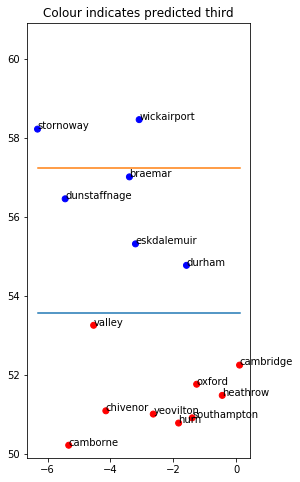

In [62]:
predDf = Xtest
predDf['latThirdPred'] = pred
predDf['lat'] = [weatherData.loc[station,'lat'] for station in Xtest.index.get_level_values('station')]
predDf['long'] = [weatherData.loc[station,'long'] for station in Xtest.index.get_level_values('station')]
makeMap(predDf,predict=True)
plt.title('Colour indicates predicted third')
plt.savefig('../results/predictedClassifier.png')

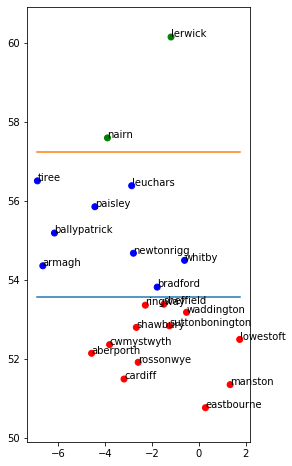

In [60]:
trainDf = Xtrain
trainDf['latThirdActual'] = yTrain
trainDf['lat'] = [weatherData.loc[station,'lat'] for station in trainDf.index.get_level_values('station')]
trainDf['long'] = [weatherData.loc[station,'long'] for station in trainDf.index.get_level_values('station')]
makeMap(trainDf)
plt.savefig('../results/trainingSet.png')

## Experiment with using month as a feature

In [22]:

weatherData = pd.DataFrame([stationData.loc[(station,slice(None),month)].median() for station in stations for month in range(1,12+1) ])
keys = [{'station' : station,'month' : month} for station in stations for month in range(1,12+1) ]
weatherData['station'] = [val['station'] for val in keys]
weatherData['month'] = [val['month'] for val in keys]
weatherData.set_index(['station'],inplace=True)
#weatherData = pd.DataFrame([weatherData.loc[(station,slice(None))].mean() for station in stations])
#weatherData['station'] = stations
#weatherData.set_index(['station'],inplace=True)
weatherData['latThirdActual'] = weatherData['lat'].apply(getThird)
weatherData

from sklearn.neighbors import KNeighborsClassifier
lr =  KNeighborsClassifier()

X,y = weatherData[['tmax','tmin','af','rain','sun','month']], weatherData['latThirdActual']
# Without this standardisation get a really bad score.
X=X/X.std()
Xtrain,Xtest,yTrain,yTest = sk.model_selection.train_test_split(X,y,train_size=0.8)
reg = lr.fit(Xtrain,yTrain)
print(reg.score(Xtrain,yTrain))
pred = reg.predict(Xtest)
print(accuracy_score(yTest,pred))

0.7014084507042253
0.5842696629213483


0.7070422535211267
0.6404494382022472
